In [ ]:
!pip install lightgbm shap lime alibi treeinterpreter

In [ ]:
!pip install eli5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.4/108.4 kB 7.2 MB/s eta 0:00:00


# Imports

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.base import clone
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from treeinterpreter import treeinterpreter as ti
from sklearn.ensemble import RandomForestClassifier
import eli5
from eli5.sklearn import PermutationImportance
from IPython.display import display

In [ ]:
X_train = pd.read_csv('/content/X_train_final.csv')
X_test = pd.read_csv('/content/X_test_final.csv')
y_train = pd.read_csv('/content/y_train_final.csv').squeeze()
y_test = pd.read_csv('/content/y_test_final.csv').squeeze()

In [ ]:
for df in [X_train, X_test]:
    df.columns = df.columns.str.replace(r"[\[\]\(\),<]", "_", regex=True)
    df.columns = df.columns.str.replace(r"\s+", "_", regex=True)

In [ ]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name} Evaluation")
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")
    print(f"Precision: {precision_score(y_test, y_pred):.2f}")
    print(f"Recall: {recall_score(y_test, y_pred):.2f}")
    print(f"F1 Score: {f1_score(y_test, y_pred):.2f}")
    print(f"AUC: {roc_auc_score(y_test, y_pred):.2f}")
    print("Classification Report:\n", classification_report(y_test, y_pred))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# EGBM Model


EGBM (GradientBoostingClassifier) Evaluation
Accuracy: 0.94
Precision: 0.94
Recall: 0.95
F1 Score: 0.94
AUC: 0.94
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93       544
           1       0.94      0.95      0.94       635

    accuracy                           0.94      1179
   macro avg       0.94      0.94      0.94      1179
weighted avg       0.94      0.94      0.94      1179



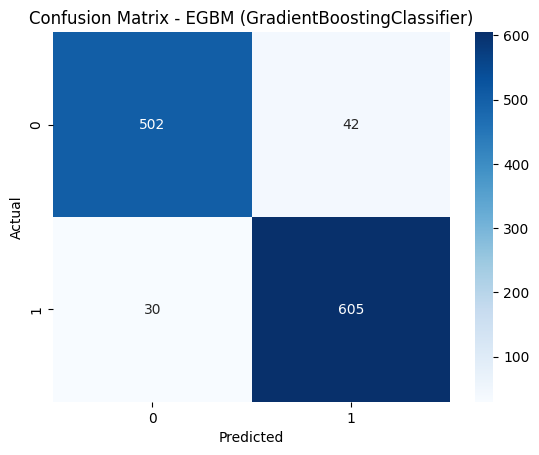

In [ ]:
eg_bm = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42)
eg_bm.fit(X_train, y_train)
evaluate_model("EGBM (GradientBoostingClassifier)", eg_bm, X_test, y_test)

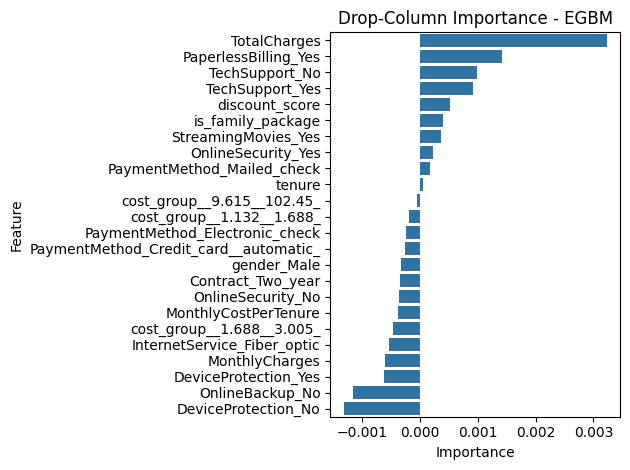

In [ ]:
def drop_column_importance(model, X_train, y_train, X_test, y_test):
    baseline_score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
    importances = {}
    for col in X_train.columns:
        X_train_drop = X_train.drop(columns=col)
        X_test_drop = X_test.drop(columns=col)
        temp_model = clone(model)
        temp_model.fit(X_train_drop, y_train)
        drop_score = roc_auc_score(y_test, temp_model.predict_proba(X_test_drop)[:, 1])
        importances[col] = baseline_score - drop_score
    importance_df = pd.DataFrame(importances.items(), columns=["Feature", "Importance"])
    importance_df = importance_df.sort_values(by="Importance", ascending=False)
    sns.barplot(x="Importance", y="Feature", data=importance_df)
    plt.title("Drop-Column Importance - EGBM")
    plt.tight_layout()
    plt.show()

drop_column_importance(eg_bm, X_train, y_train, X_test, y_test)

Drop-Column Importance Interpretation – EGBM
The drop-column feature importance plot quantifies how much each feature contributes to the predictive power of the EGBM model by measuring the decrease in AUC when a feature is removed.

Top Positive Contributors:
* TotalCharges is the most influential feature. Its removal significantly degrades model performance, indicating that the cumulative billing amount plays a vital role in predicting churn.

* PaperlessBilling_Yes and TechSupport_No are also strong predictors. The former reflects billing preferences linked to churn behavior, while the latter highlights the importance of support services.

* Other features like discount_score, is_family_package, and StreamingMovies_Yes have moderate influence, reinforcing the role of customer incentives and service engagement.

Neutral or Weak Impact Features:
* Some features like PaymentMethod_Credit_card_automatic and gender_Male have negligible importance, indicating minimal contribution to the model’s discrimination power.

* MonthlyCostPerTenure, though significant in SHAP and PDP analyses, appears less impactful here, possibly due to redundancy with other correlated billing features.

Features with Negative Importance:
* DeviceProtection_No, OnlineBackup_No, and DeviceProtection_Yes have slight negative importance scores. This counterintuitive result may stem from:

    * Multicollinearity: Their predictive power might be captured by correlated features.

    * Regularization effect: Their removal may reduce overfitting, slightly improving generalization.

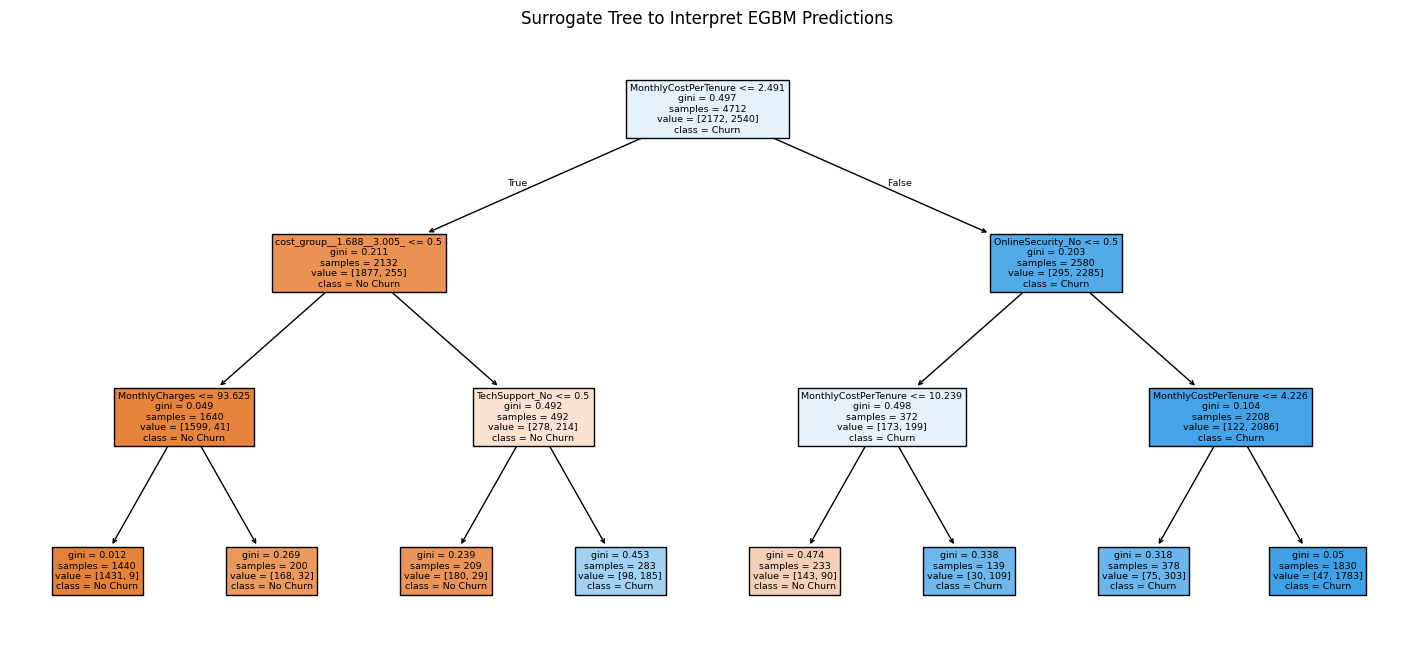

In [ ]:
surrogate = DecisionTreeClassifier(max_depth=3, random_state=42)
surrogate.fit(X_train, eg_bm.predict(X_train))
plt.figure(figsize=(18, 8))
tree.plot_tree(surrogate, feature_names=X_train.columns, class_names=['No Churn', 'Churn'], filled=True)
plt.title("Surrogate Tree to Interpret EGBM Predictions")
plt.show()

Surrogate Decision Tree Interpretation – EGBM

The surrogate tree provides a simplified, interpretable representation of the complex EGBM model by learning from its predictions. It enables visualization of key decision rules driving churn predictions.

Root Decision:
* MonthlyCostPerTenure ≤ 2.491 is the most important split in the tree.

  * This confirms previous insights (SHAP, PDP, LIME) that high cost relative to tenure is a critical churn driver.

  * Customers below this threshold are generally less likely to churn.

Left Subtree (Lower MonthlyCostPerTenure):
* Further split on cost_group and MonthlyCharges:

    * Customers with lower MonthlyCharges (≤ 93.625) and modest cost_group values show extremely low churn probability.

    * When MonthlyCharges rise or support services are missing (TechSupport_No > 0.5), churn risk increases.

Right Subtree (Higher MonthlyCostPerTenure):
* OnlineSecurity_No becomes a decisive feature:

    * Absence of online security leads to higher churn likelihood.

    * For those with higher MonthlyCostPerTenure and no security, churn rates are especially high.

* This subtree represents the highest risk customers: those paying more early in their contract and lacking protective services.

Key Insights:
* Low-cost, long-tenure customers with support services are strongly associated with No Churn.

* High-cost, short-tenure customers without support/security services are strongly associated with Churn.

* Features like TechSupport_No, OnlineSecurity_No, and MonthlyCharges act as amplifiers of churn when combined with high cost per tenure.

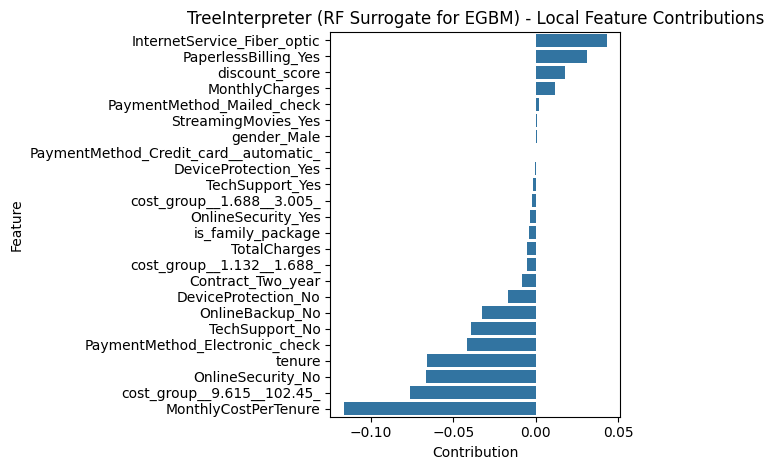

In [ ]:
rf_surrogate = RandomForestClassifier(n_estimators=100, max_depth=6, random_state=42)
rf_surrogate.fit(X_train, eg_bm.predict(X_train))

instance = X_test.iloc[[0]]
instance_array = instance.to_numpy()

prediction, bias, contributions = ti.predict(rf_surrogate, instance_array)

class_index = int(prediction[0][0])

flat_contributions = contributions[0][:, class_index]

contrib_df = pd.DataFrame({
    "Feature": X_test.columns,
    "Contribution": flat_contributions
}).sort_values(by="Contribution", ascending=False)

# Plot
sns.barplot(x="Contribution", y="Feature", data=contrib_df)
plt.title("TreeInterpreter (RF Surrogate for EGBM) - Local Feature Contributions")
plt.tight_layout()
plt.show()


Local Explanation – TreeInterpreter (EGBM via RF Surrogate)

This bar chart visualizes the individual-level contribution of each feature to the EGBM model's prediction for a single customer instance, using a Random Forest surrogate model interpreted by treeinterpreter.

Key Positive Contributors (Features Increasing Churn Prediction):
* MonthlyCostPerTenure: The largest contributor pushing the prediction toward churn. High cost per tenure is strongly associated with dissatisfaction or perceived unfairness.

* cost_group__9.615__102.45_ and OnlineSecurity_No: These also have sizable positive contributions, indicating that high total cost and lack of security services both raise churn likelihood.

* PaymentMethod_Electronic_check, TechSupport_No, and DeviceProtection_No: Absence of support and protective services, along with risky payment methods, further reinforce churn prediction.

Key Negative Contributors (Features Decreasing Churn Prediction):
* InternetService_Fiber_optic, PaperlessBilling_Yes, and discount_score: These features work against the churn prediction. For instance:

    * discount_score might reflect a financial incentive helping retain the customer.

    * PaperlessBilling_Yes suggests digital-savvy behavior or greater engagement.

    * Fiber-optic internet could indicate satisfaction with service quality.

Overall Conclusion:

* The prediction is primarily driven by financial stress (high cost per tenure) and lack of customer care services (no security/support).

* Loyalty indicators like discounts, fiber-optic service, and paperless billing act as retention signals and reduce churn risk.

In [ ]:
perm = PermutationImportance(eg_bm, random_state=42, scoring='roc_auc')
perm.fit(X_test, y_test)

display(eli5.show_weights(perm, feature_names=X_test.columns.tolist()))

Weight,Feature
0.1651 ± 0.0195,MonthlyCostPerTenure
0.0136 ± 0.0032,TotalCharges
0.0110 ± 0.0022,TechSupport_No
0.0061 ± 0.0006,OnlineSecurity_No
0.0060 ± 0.0016,MonthlyCharges
0.0053 ± 0.0014,DeviceProtection_No
0.0041 ± 0.0013,cost_group__1.688__3.005_
0.0040 ± 0.0013,PaperlessBilling_Yes
0.0035 ± 0.0014,PaymentMethod_Electronic_check
0.0023 ± 0.0011,DeviceProtection_Yes


The ELI5 permutation importance results for the EGBM model highlight MonthlyCostPerTenure as the most critical feature influencing churn predictions, with a substantially higher importance weight than all other variables.

This reinforces earlier findings that customers paying a high amount relative to their tenure are at the greatest risk of churn.

Other important contributors include TotalCharges, TechSupport_No, and OnlineSecurity_No, indicating that high cumulative billing and lack of support or security services are strong signals of dissatisfaction.

 MonthlyCharges and DeviceProtection_No also play notable roles, reflecting the impact of ongoing service costs and the absence of protective offerings.

 Conversely, features such as InternetService_Fiber_optic, gender_Male, and certain cost groups exhibit low permutation importance, suggesting they contribute little to the model’s discriminative power when assessed in isolation.

  Overall, the model's decision-making heavily relies on billing pressure and service coverage, with ELI5 providing a transparent, global view of how feature shuffling affects predictive performance.